In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from scipy.stats import zscore

# Sklearn imports for scaling, splitting, modeling, evaluation, and hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Additional libraries for boosting models
import xgboost as xgb
# import lightgbm as lgb
# from catboost import CatBoostClassifier

In [7]:
# Example: Download data using yfinance library (install it if needed: pip install yfinance)
import yfinance as yf

# Define the ticker symbol (e.g., "AAPL" for Apple Inc.)
ticker = "AAPL"

# Download historical data (last 5 years)
data = yf.download(ticker, period="5y", interval="1d")

# Save the data to a CSV file for later use
data.to_csv("data/stock_data.csv")

# Display the first few rows
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-03-09,64.593887,67.486618,63.824591,64.006601,286744800
2020-03-10,69.246033,69.512981,65.370448,67.256069,285290000
2020-03-11,66.841072,68.246186,65.974706,67.316728,255598800
2020-03-12,60.240211,65.523335,60.184396,62.111268,418474000
2020-03-13,67.457497,67.930724,61.385666,64.283258,370732000


In [8]:
df = pd.read_csv(
    "data/stock_data.csv",
    skiprows=3,                # Skip the first two lines
    names=["Date", "Close", "High", "Low", "Open", "Volume"]
)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
print(df.head())
print("\nData Description:")
print(df.describe())


                Close       High        Low       Open     Volume
Date                                                             
2020-03-09  64.593887  67.486618  63.824591  64.006601  286744800
2020-03-10  69.246033  69.512981  65.370448  67.256069  285290000
2020-03-11  66.841072  68.246186  65.974706  67.316728  255598800
2020-03-12  60.240211  65.523335  60.184396  62.111268  418474000
2020-03-13  67.457497  67.930724  61.385666  64.283258  370732000

Data Description:
             Close         High          Low         Open        Volume
count  1256.000000  1256.000000  1256.000000  1256.000000  1.256000e+03
mean    157.821496   159.413864   156.049043   157.669559  8.674388e+07
std      42.092619    42.254612    41.835021    42.030831  5.017888e+07
min      54.449886    55.452152    51.595983    55.350227  2.323470e+07
25%     130.701015   132.040753   129.038160   130.765520  5.379620e+07
50%     155.102379   157.345465   152.625028   155.106449  7.371300e+07
75%     181.741

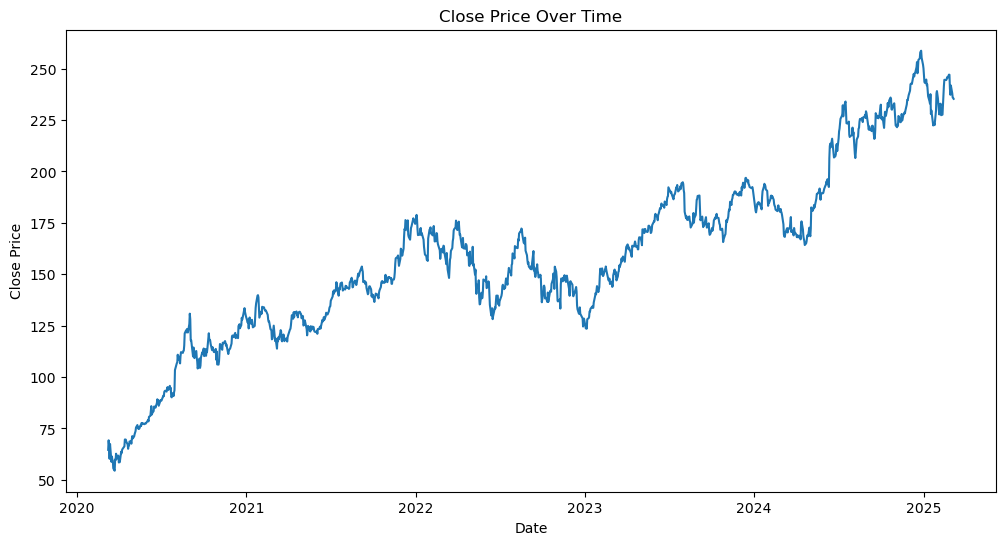

In [9]:
# Plot the Close price over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [10]:
# ---------------------------
# Outlier Detection & Handling
# ---------------------------
# Remove outliers from the 'Close' column using a z-score threshold (|z| < 3)
df['Close_z'] = zscore(df['Close'])
df = df[df['Close_z'].abs() < 3]
df.drop(columns=['Close_z'], inplace=True)

In [11]:
# ---------------------------
# Feature Engineering
# ---------------------------
# Create Technical Indicators using ta (instead of pandas_ta)

# 1. Simple Moving Average (SMA) for a 20-day period
df['SMA20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()

# 2. Exponential Moving Average (EMA) for a 20-day period
df['EMA20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

# 3. Relative Strength Index (RSI) with a 14-day period
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

# 4. Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Hist'] = macd.macd_diff()

# Drop initial rows with NaNs after indicator calculations
df.dropna(inplace=True)

# Generate "Returns" Feature: daily percentage change in 'Close'
df['Return'] = df['Close'].pct_change()
df.dropna(inplace=True)

# Define the binary Target: 1 if next day's Close > today's, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.dropna(inplace=True)

# print(df.head())

In [14]:
# Cell: Fetch and Process News Sentiment from a News API
import requests
import datetime
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Replace with your NewsAPI key
api_key = "44e0b7ac8f2247c18afa1ffc06168edd"

# Define a date range (for example, one day or a range)
# Use recent dates (e.g., last week) instead of 2022
start_date = datetime.date.today() - datetime.timedelta(days=30)
end_date = datetime.date.today()


daily_sentiments = []
sia = SentimentIntensityAnalyzer()

current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime("%Y-%m-%d")
    url = f"https://newsapi.org/v2/everything?q=Apple&from={date_str}&to={date_str}&sortBy=popularity&apiKey={api_key}"
    
    response = requests.get(url)
    if response.status_code == 200:
        news_data = response.json()
        headlines = [article['title'] for article in news_data.get('articles', [])]
        if headlines:
            sentiments = [sia.polarity_scores(headline)['compound'] for headline in headlines]
            avg_sentiment = np.mean(sentiments)
            daily_sentiments.append({'date': date_str, 'num_headlines': len(headlines), 'avg_sentiment': avg_sentiment})
            # print(headlines)
            # print(f"Date: {date_str} | Headlines: {len(headlines)} | Avg Sentiment: {avg_sentiment:.4f}")
        else:
            print(f"Date: {date_str} | No headlines found.")
    else:
        print(f"Error fetching news for {date_str}: {response.status_code}")
    current_date += datetime.timedelta(days=1)

# Check if data was collected
if not daily_sentiments:
    print("No sentiment data was collected.")
else:
    df_sentiment = pd.DataFrame(daily_sentiments)
    # print("Keys in the sentiment data:", df_sentiment.columns)
    # Convert and set the index if the 'date' key is present
    if 'date' in df_sentiment.columns:
        df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
        df_sentiment.set_index('date', inplace=True)
    # print("\nDaily aggregated sentiment:")
    # print(df_sentiment)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Error fetching news for 2025-02-06: 429
Error fetching news for 2025-02-07: 429
Error fetching news for 2025-02-08: 429
Error fetching news for 2025-02-09: 429
Error fetching news for 2025-02-10: 429
Error fetching news for 2025-02-11: 429
Error fetching news for 2025-02-12: 429
Error fetching news for 2025-02-13: 429
Error fetching news for 2025-02-14: 429
Error fetching news for 2025-02-15: 429
Error fetching news for 2025-02-16: 429
Error fetching news for 2025-02-17: 429
Error fetching news for 2025-02-18: 429
Error fetching news for 2025-02-19: 429
Error fetching news for 2025-02-20: 429
Error fetching news for 2025-02-21: 429
Error fetching news for 2025-02-22: 429
Error fetching news for 2025-02-23: 429
Error fetching news for 2025-02-24: 429
Error fetching news for 2025-02-25: 429
Error fetching news for 2025-02-26: 429
Error fetching news for 2025-02-27: 429
Error fetching news for 2025-02-28: 429
Error fetching news for 2025-03-01: 429
Error fetching news for 2025-03-02: 429


In [15]:
# ---------------------------
# Part 3: Merge Sentiment Data into the Technical Data
# ---------------------------
# Merge the sentiment data with the technical data based on the Date index.
enhanced_df = df.join(df_sentiment, how='left')

# For days without sentiment data, fill missing values with neutral sentiment (0) and 0 headlines.
if 'avg_sentiment' in enhanced_df.columns:
    enhanced_df['avg_sentiment'] = enhanced_df['avg_sentiment'].fillna(0)
    
if 'num_headlines' in enhanced_df.columns:
    enhanced_df['num_headlines'] = enhanced_df['num_headlines'].fillna(0)

# print("Enhanced DataFrame with Sentiment:")
# print(enhanced_df.head())

NameError: name 'df_sentiment' is not defined

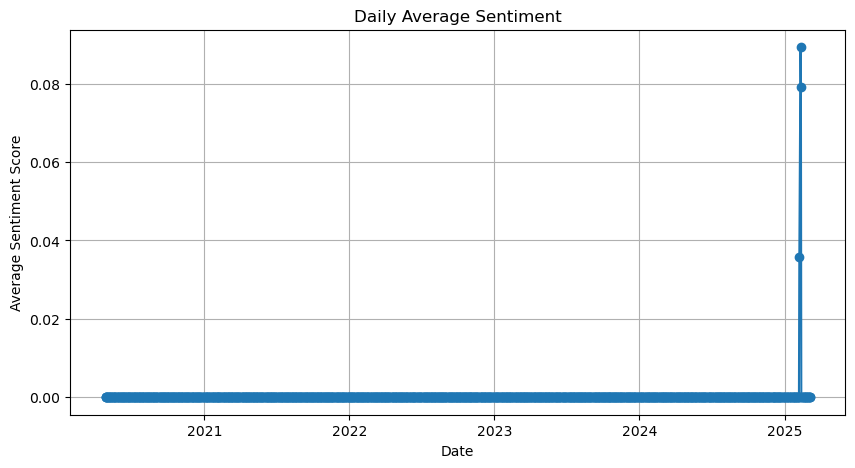

In [11]:
# Optionally, plot the daily average sentiment for visual inspection.
if 'avg_sentiment' in enhanced_df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(enhanced_df.index, enhanced_df['avg_sentiment'], marker='o')
    plt.title("Daily Average Sentiment")
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment Score")
    plt.grid(True)
    plt.show()

# Save the enhanced dataset for future use
enhanced_df.to_csv("data/enhanced_stock_data.csv")

In [12]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\johni\AppData\Roaming\gcloud\application_default_credentials.json"


In [13]:
import os
credentials_path = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
if credentials_path:
    print("Credentials loaded from:", credentials_path)
else:
    print("No GOOGLE_APPLICATION_CREDENTIALS variable set; Application Default Credentials will be used.")


Credentials loaded from: C:\Users\johni\AppData\Roaming\gcloud\application_default_credentials.json


In [14]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

def fetch_gdelt_sentiment_apple():
    """
    Queries the GDELT v2 events dataset in BigQuery to retrieve daily average tone
    for rows that mention 'APPLE' in Actor1Name or Actor2Name over the last ~6 months.
    Returns a DataFrame with columns: ['gdelt_sentiment'] indexed by date.
    """
    # Initialize BigQuery client with your project ID (replace with your actual project ID)
    client = bigquery.Client(project="machinelearning111")
    
    # Updated query using SQLDATE instead of EventDate
    query = """
    WITH filtered AS (
      SELECT
        PARSE_DATE('%Y%m%d', CAST(SQLDATE AS STRING)) AS event_date,
        AvgTone
      FROM
        `gdelt-bq.gdeltv2.events`
      WHERE
        PARSE_DATE('%Y%m%d', CAST(SQLDATE AS STRING)) >= DATE_SUB(CURRENT_DATE(), INTERVAL 5 YEAR)
        AND (
          LOWER(Actor1Name) LIKE '%apple%'
          OR LOWER(Actor2Name) LIKE '%apple%'
        )
    )
    SELECT
      event_date AS date,
      AVG(AvgTone) AS daily_tone
    FROM filtered
    GROUP BY date
    ORDER BY date
    """
    
    job = client.query(query)
    results = job.result()
    rows = list(results)
    
    # Convert results to DataFrame
    data = []
    for row in rows:
        data.append({'date': row.date, 'daily_tone': row.daily_tone})
    
    df_gdelt = pd.DataFrame(data)
    if not df_gdelt.empty:
        df_gdelt.set_index('date', inplace=True)
        df_gdelt.rename(columns={'daily_tone': 'gdelt_sentiment'}, inplace=True)
    else:
        df_gdelt = pd.DataFrame(columns=['gdelt_sentiment'])
    
    return df_gdelt

# Fetch GDELT data
df_gdelt = fetch_gdelt_sentiment_apple()
# print("\nGDELT DataFrame (Apple mentions) Head:")
# print(df_gdelt.head(50))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
# ---------------------------
# Part 3: Merge GDELT Sentiment into Technical Data
# ---------------------------
# Merge by date: Both DataFrames use the date as their index
even_enhanced_df = enhanced_df.join(df_gdelt, how='left')

# For days without GDELT data, fill missing values with 0
even_enhanced_df['gdelt_sentiment'] = even_enhanced_df['gdelt_sentiment'].fillna(0)

# print("Enhanced DataFrame with GDELT Sentiment:")
# print(even_enhanced_df.head())

# Save the final enhanced DataFrame
even_enhanced_df.to_csv("data/even_enhanced_stock_data.csv")

In [16]:
from fredapi import Fred

# Set your FRED API key here
fred_api_key = "7841d255497334b51d98c59632502130"  # Replace with your FRED API key
fred = Fred(api_key=fred_api_key)

# Define the date range for macro data based on your stock data
start_date_macro = df.index.min().strftime('%Y-%m-%d')
end_date_macro = df.index.max().strftime('%Y-%m-%d')
# print(start_date_macro, end_date_macro)

# Fetch daily interest rates (10-Year Treasury Constant Maturity Rate)
dgs10 = fred.get_series('DGS10', start_date_macro, end_date_macro)
df_dgs10 = pd.DataFrame(dgs10, columns=['DGS10'])
df_dgs10.index = pd.to_datetime(df_dgs10.index)

# print(df_dgs10.head(10))
# Fetch monthly CPI data
cpi = fred.get_series('CPIAUCSL', start_date_macro, end_date_macro)
df_cpi = pd.DataFrame(cpi, columns=['CPI'])
df_cpi.index = pd.to_datetime(df_cpi.index)
# Resample CPI to daily frequency using forward fill
df_cpi_daily = df_cpi.resample('D').ffill()
# print(df_cpi.head(100))
# print(df_cpi_daily.head(100))
# Fetch quarterly GDP data
gdp = fred.get_series('GDP', start_date_macro, end_date_macro)
df_gdp = pd.DataFrame(gdp, columns=['GDP'])
df_gdp.index = pd.to_datetime(df_gdp.index)
# Resample GDP to daily frequency using forward fill
df_gdp_daily = df_gdp.resample('D').ffill()
# print(df_gdp.head(100))
# print(df_gdp_daily.head(100))
# Merge macro indicators into one DataFrame
macro_df = df_dgs10.join(df_cpi_daily, how='outer').join(df_gdp_daily, how='outer')
macro_df = macro_df.ffill()
macro_df.fillna(0, inplace=True)  # For any remaining NaNs
macro_df.head()

,DGS10,CPI,GDP
2020-04-01,0.0,256.032,19935.444
2020-04-02,0.0,256.032,19935.444
2020-04-03,0.0,256.032,19935.444
2020-04-04,0.0,256.032,19935.444
2020-04-05,0.0,256.032,19935.444


In [17]:
# ---------------------------
# Part 3: Merge Macro Data into Stock Data
# ---------------------------
# Merge the macro DataFrame with the technical stock DataFrame based on the date index
even_enhanced_df = df.join(macro_df, how='left')
# Fill missing macro values with the last available value or 0 if still missing
even_enhanced_df['DGS10'] = even_enhanced_df['DGS10'].ffill().fillna(0)
even_enhanced_df['CPI'] = even_enhanced_df['CPI'].ffill().fillna(0)
even_enhanced_df['GDP'] = even_enhanced_df['GDP'].ffill().fillna(0)

# print("Enhanced DataFrame with Macro Indicators:")
# print(even_enhanced_df.head())

# ---------------------------
# (Optional) Save the enhanced dataset
# ---------------------------
even_enhanced_df.to_csv("data/enhanced_stock_data_with_macro.csv")

In [21]:
# Import the necessary library from pytrends
from pytrends.request import TrendReq

# Step 1: Set up a connection to Google Trends using pytrends.
# Think of it as opening a door to ask Google about search trends.
pytrends = TrendReq(hl='en-US', tz=360)

# Step 2: Define the search term and the time period.
# We'll search for "Apple" (the company) and use a timeframe that matches our stock data.
# For example, if our stock data is from 5 years ago until today,
# we build a string with those dates.
timeframe = "all"

# List of keywords to search for. We use a list even if it has one item.
kw_list = ["Apple"]

# Step 3: Build the payload.
# This tells Google Trends what we want to know.
pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='', gprop='')

# Step 4: Fetch the interest over time.
# Google Trends will return a DataFrame where each row is a date and the value is how popular "Apple" is.
# Wrap in try/except to handle rate limiting
try:
    pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    if 'isPartial' in interest_over_time_df.columns:
        interest_over_time_df = interest_over_time_df.drop(columns=['isPartial'])
except TooManyRequestsError as e:
    print("Too many requests. Waiting for 60 seconds before retrying...")
    time.sleep(60)
    pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    if 'isPartial' in interest_over_time_df.columns:
        interest_over_time_df = interest_over_time_df.drop(columns=['isPartial'])
# Print the first few rows so we can see what it looks like.
print("Google Trends Interest Over Time for 'Apple':")
print(interest_over_time_df.head())

# Optional: If the data is weekly and you want daily values,
# you could resample it (for example, using forward fill). Uncomment if needed.
# interest_over_time_daily = interest_over_time_df.resample('D').ffill()
# print("Resampled Daily Google Trends Data:")
# print(interest_over_time_daily.head())


Google Trends Interest Over Time for 'Apple':
            Apple
date             
2004-01-01     21
2004-02-01     19
2004-03-01     18
2004-04-01     19
2004-05-01     18


D:\Users\johni\anaconda3\envs\stock_env\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


In [22]:
# ---------------------------
# Merge Google Trends Data into Enhanced DataFrame
# ---------------------------
# 'even_enhanced_df' is your DataFrame with stock, macro, news, and GDELT data
# It is indexed by date; join on date
even_enhanced_df = even_enhanced_df.join(interest_over_time_df, how='left')
# Fill missing values in the "Apple" column with the last available value, then with 0 if still missing
even_enhanced_df['Apple'] = even_enhanced_df['Apple'].ffill().fillna(0)

# ---------------------------
# Final: Save the Fully Enhanced Dataset
# ---------------------------
even_enhanced_df.to_csv("data/even_enhanced_stock_data.csv")
# even_enhanced_df.head(50)

In [39]:
featured_df = even_enhanced_df.copy()
# Create a group column where each row is labeled by its trading day.
featured_df['group'] = featured_df.index.date
# Verify that the group labels are set correctly
print(featured_df[['group']].head())

                 group
Date                  
2020-04-27  2020-04-27
2020-04-28  2020-04-28
2020-04-29  2020-04-29
2020-04-30  2020-04-30
2020-05-01  2020-05-01


In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# Fixed PurgedEmbargoedTimeSeriesSplit with embargo applied to the test set.
class PurgedEmbargoedTimeSeriesSplit(_BaseKFold):
    """Custom Time-Series CV that purges a specified gap between training and test sets 
    and applies an embargo period to shift the test set.
    
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits/folds.
    purge : int, default=0
        Number of groups to exclude immediately before the test set.
    embargo : int, default=0
        Number of groups to shift the test set forward (embargo period).
    max_train_group_size : int, default=np.inf
        Optional maximum number of groups for training.
    """
    @_deprecate_positional_args
    def __init__(self, n_splits=5, *, purge=0, embargo=0, max_train_group_size=np.inf):
        if n_splits < 2:
            raise ValueError("n_splits must be at least 2.")
        self.n_splits = n_splits
        self.purge = purge
        self.embargo = embargo
        self.max_train_group_size = max_train_group_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test sets.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data to split.
        y : array-like, optional
            Not used, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels (e.g., trading days). Must be provided.
            
        Yields
        ------
        train : ndarray
            The training set indices for that fold.
        test : ndarray
            The test set indices for that fold.
        """
        if groups is None:
            raise ValueError("The 'groups' parameter must be provided.")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        # Obtain unique groups in order of appearance
        unique_groups, group_start_idx = np.unique(groups, return_index=True)
        sorted_groups = unique_groups[np.argsort(group_start_idx)]
        n_groups = len(sorted_groups)
        
        if self.n_splits + 1 > n_groups:
            raise ValueError("Not enough groups for the number of splits requested.")
        
        # Determine test group size (number of groups per test fold)
        test_group_size = n_groups // (self.n_splits + 1)
        
        for i in range(self.n_splits):
            raw_test_start = (i + 1) * test_group_size
            # Training groups: groups before raw_test_start minus purge gap.
            train_end = max(raw_test_start - self.purge, 0)
            train_groups = sorted_groups[:train_end]
            # If a maximum train group size is defined, keep only the latest groups.
            if len(train_groups) > self.max_train_group_size:
                train_groups = train_groups[-self.max_train_group_size:]
            
            # Apply embargo: shift test set forward by embargo groups.
            actual_test_start = raw_test_start + self.embargo
            actual_test_end = actual_test_start + test_group_size
            test_groups = sorted_groups[actual_test_start:actual_test_end]
            
            # Convert group labels to indices
            train_idx = np.hstack([np.where(groups == grp)[0] for grp in train_groups])
            test_idx = np.hstack([np.where(groups == grp)[0] for grp in test_groups])
            
            yield train_idx, test_idx




In [41]:
# ---------------------------
# Testing the PurgedEmbargoedTimeSeriesSplit Function
# ---------------------------
# Create synthetic data with a group label.
# For simplicity, let's assume we have 30 days of data.
dates = pd.date_range(start='2022-01-01', periods=30, freq='D')
# We'll use the date (as string) as the group label.
groups = dates.strftime('%Y-%m-%d').values

# Create a dummy feature matrix (30 samples, 2 features) and target vector.
X_dummy = np.random.randn(30, 2)
y_dummy = np.random.randint(0, 2, size=(30,))

# Instantiate the splitter with, for example, 3 splits, a purge of 1 group, and an embargo of 1 group.
cv = PurgedEmbargoedTimeSeriesSplit(n_splits=3, purge=1, embargo=1)

# Print the training and test groups for each fold.
print("Testing PurgedEmbargoedTimeSeriesSplit:")
for fold, (train_idx, test_idx) in enumerate(cv.split(X_dummy, y_dummy, groups=groups), 1):
    print(f"\nFold {fold}:")
    print("Training groups:", np.unique(groups[train_idx]))
    print("Test groups:", np.unique(groups[test_idx]))
    # For clarity, print the indices too.
    print("Train indices:", train_idx)
    print("Test indices:", test_idx)

Testing PurgedEmbargoedTimeSeriesSplit:

Fold 1:
Training groups: ['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06']
Test groups: ['2022-01-09' '2022-01-10' '2022-01-11' '2022-01-12' '2022-01-13'
 '2022-01-14' '2022-01-15']
Train indices: [0 1 2 3 4 5]
Test indices: [ 8  9 10 11 12 13 14]

Fold 2:
Training groups: ['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06' '2022-01-07' '2022-01-08' '2022-01-09' '2022-01-10'
 '2022-01-11' '2022-01-12' '2022-01-13']
Test groups: ['2022-01-16' '2022-01-17' '2022-01-18' '2022-01-19' '2022-01-20'
 '2022-01-21' '2022-01-22']
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Test indices: [15 16 17 18 19 20 21]

Fold 3:
Training groups: ['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06' '2022-01-07' '2022-01-08' '2022-01-09' '2022-01-10'
 '2022-01-11' '2022-01-12' '2022-01-13' '2022-01-14' '2022-01-15'
 '2022-01-16' '2022-01-17' '2022-01-18' '2022-01-19' '202

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- Step 1: Load Enhanced Data ---
# Load your fully enhanced dataset (technical, sentiment, macro, and Google Trends merged)
print("Initial Enhanced DataFrame Shape:", featured_df.shape)
# print(featured_df.head(10))

# --- Step 2: Data Filtering ---
# Optionally, filter out early data if you suspect quality issues
# featured_df = featured_df[featured_df.index > '2020-03-01']

# --- Step 3: Handle Missing Values ---
# Forward-fill missing values and then fill any remaining NaNs with 0
featured_df.fillna(method='ffill', inplace=True)
featured_df.fillna(0, inplace=True)


# --- Step 5: Compute Sample Weights (Optional) ---
# Compute a rolling average of absolute daily returns to serve as sample weights
featured_df['sample_weight'] = featured_df['Return'].abs().rolling(window=5).mean().fillna(1)

# --- Step 6: Define Features and Prepare Data ---
# Exclude the target and sample_weight columns from the features
feature_cols = [col for col in featured_df.columns if col not in ['Target', 'sample_weight', 'group']]
X = featured_df[feature_cols]
y = featured_df['Target']
sample_weight = featured_df['sample_weight']

# --- Step 7: Scale Features ---
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

# --- Step 8: (Optional) Chronological Train/Test Split ---
# This step is useful for later modeling; here we print sizes for verification.
train_size = int(len(X_scaled) * 0.8)
X_train = X_scaled.iloc[:train_size]
X_test  = X_scaled.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]
sw_train = sample_weight.iloc[:train_size]

print("Training set size:", X_train.shape, " Testing set size:", X_test.shape)
print("Sample target distribution (first 5 rows):")
print(y_train.head())
print(X_train.head())
# At this point, your data is preprocessed similarly to the winning code,
# but adapted to your stock data. You don't have multiple 'resp' columns,
# so you don't need to create a composite target from them.
# Instead, you use a single target based on the next day's Close price.
# You also compute sample weights based on volatility (absolute returns).


Initial Enhanced DataFrame Shape: (1222, 19)
Training set size: (977, 16)  Testing set size: (245, 16)
Sample target distribution (first 5 rows):
Date
2020-04-27    0
2020-04-28    1
2020-04-29    1
2020-04-30    0
2020-05-01    1
Name: Target, dtype: int64
               Close      High       Low      Open    Volume     SMA20  \
Date                                                                     
2020-04-27 -2.319488 -2.341803 -2.309293 -2.328193  0.800432 -2.380723   
2020-04-28 -2.347655 -2.333920 -2.320103 -2.308030  0.681587 -2.373414   
2020-04-29 -2.291506 -2.310452 -2.284956 -2.310181  1.272585 -2.363132   
2020-04-30 -2.254259 -2.280753 -2.257408 -2.278032  2.343078 -2.346870   
2020-05-01 -2.283284 -2.253436 -2.272850 -2.300837  3.688766 -2.333298   

               EMA20       RSI      MACD  MACD_Signal  MACD_Hist    Return  \
Date                                                                         
2020-04-27 -2.369158  0.330187  0.201730     0.168858   0.136620 -0

C:\Users\johni\AppData\Local\Temp\ipykernel_5704\642025837.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  featured_df.fillna(method='ffill', inplace=True)


In [1]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

# Assume your preprocessed data is available:
# X_scaled: DataFrame of scaled features
# y: Series of binary targets (we need to reshape to (-1, 1))
# sample_weight: Series of sample weights
# Also, assume your index (or a 'group' column) is available for CV splitting.

# Convert target to proper shape
y_array = y.values.reshape(-1, 1)

# Define hyperparameters for the model (adjust as needed)
params = {
    'num_columns': X_scaled.shape[1],
    'num_labels': 1,  # Single binary target
    'hidden_units': [96, 96, 896, 448, 448, 256],  # example architecture; adjust as needed
    'dropout_rates': [0.0353, 0.0384, 0.4241, 0.1043, 0.4923, 0.3202, 0.2717, 0.4379],
    'ls': 0,      # label smoothing parameter
    'lr': 1e-3,   # learning rate
}

# Custom Time-Series CV Splitter
# (Assume you have defined PurgedEmbargoedTimeSeriesSplit earlier)
# Here we use the same instance; adjust purge/embargo as desired.
cv = PurgedEmbargoedTimeSeriesSplit(n_splits=5, purge=31, embargo=31)

# To use time-series splitting, we need a grouping variable.
# For instance, if your DataFrame index is dates, you can use:
groups = X_scaled.index.astype(str).values

# Initialize list to store fold scores
fold_scores = []

# Define batch size and number of epochs
batch_size = 4096
epochs = 100

# Start cross-validation training loop
fold = 0
for train_idx, val_idx in cv.split(X_scaled.values, y_array, groups=groups):
    fold += 1
    print(f"\nTraining Fold {fold}")
    
    # Create a new model instance for each fold
    model = create_ae_mlp(**params)
    
    # Define file path for model checkpoint for current fold
    ckp_path = f"model_fold_{fold}.hdf5"
    
    # Setup callbacks: save the best model based on validation AUC for 'action'
    checkpoint = ModelCheckpoint(
        ckp_path, monitor='val_action_AUC', save_best_only=True,
        save_weights_only=True, mode='max', verbose=1
    )
    earlystop = EarlyStopping(
        monitor='val_action_AUC', min_delta=1e-4, patience=10,
        restore_best_weights=True, mode='max', verbose=1
    )
    
    # Extract training and validation data
    X_train_fold = X_scaled.values[train_idx]
    X_val_fold = X_scaled.values[val_idx]
    y_train_fold = y_array[train_idx]
    y_val_fold = y_array[val_idx]
    
    # If you want to use sample weights (optional), extract them as well.
    sw_train_fold = sample_weight.values[train_idx]
    
    # Train the model:
    # Note: For the decoder, the target is the input features X itself.
    history = model.fit(
        X_train_fold,
        {
            'decoder': X_train_fold,
            'ae_action': y_train_fold,
            'action': y_train_fold
        },
        validation_data=(
            X_val_fold,
            {
                'decoder': X_val_fold,
                'ae_action': y_val_fold,
                'action': y_val_fold
            }
        ),
        sample_weight=sw_train_fold,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, earlystop],
        verbose=1
    )
    
    # Retrieve best validation AUC for the final output ('action')
    hist_df = pd.DataFrame(history.history)
    best_auc = hist_df['val_action_AUC'].max()
    print(f"Fold {fold} best validation ROC AUC: {best_auc:.4f}")
    fold_scores.append(best_auc)
    
    # Clean up session and delete model
    K.clear_session()
    del model
    gc.collect()

# Compute a simple average (or weighted average if desired) of fold AUCs
avg_auc = np.mean(fold_scores)
print("\nAverage Cross-Validation ROC AUC:", avg_auc)


NameError: name 'y' is not defined

In [26]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import yfinance as yf
import requests
import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# ---------------------------
# Data Download & Technical Feature Engineering (Your existing code)
# ---------------------------
ticker = "AAPL"
data = yf.download(ticker, period="5y", interval="1d")
data.to_csv("data/stock_data.csv")
df = pd.read_csv("data/stock_data.csv", skiprows=3, names=["Date", "Close", "High", "Low", "Open", "Volume"])
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Outlier Removal on 'Close'
df['Close_z'] = zscore(df['Close'])
df = df[df['Close_z'].abs() < 3]
df.drop(columns=['Close_z'], inplace=True)

# Technical Indicators
df['SMA20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
df['EMA20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()
df['RSI']   = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Hist'] = macd.macd_diff()
df.dropna(inplace=True)

# Returns and Target
df['Return'] = df['Close'].pct_change()
df.dropna(inplace=True)
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.dropna(inplace=True)

# ---------------------------
# News Sentiment via NewsAPI
# ---------------------------
api_key = "YOUR_NEWSAPI_KEY"  # Replace with your actual key
start_date = datetime.date.today() - datetime.timedelta(days=30)
end_date = datetime.date.today()
daily_sentiments = []
sia = SentimentIntensityAnalyzer()
current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime("%Y-%m-%d")
    url = f"https://newsapi.org/v2/everything?q=Apple&from={date_str}&to={date_str}&sortBy=popularity&apiKey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        news_data = response.json()
        headlines = [article['title'] for article in news_data.get('articles', [])]
        if headlines:
            sentiments = [sia.polarity_scores(headline)['compound'] for headline in headlines]
            avg_sentiment = np.mean(sentiments)
            daily_sentiments.append({'date': date_str, 'num_headlines': len(headlines), 'avg_sentiment': avg_sentiment})
            print(f"Date: {date_str} | Headlines: {len(headlines)} | Avg Sentiment: {avg_sentiment:.4f}")
        else:
            print(f"Date: {date_str} | No headlines found.")
    else:
        print(f"Error fetching news for {date_str}: {response.status_code}")
    current_date += datetime.timedelta(days=1)

if daily_sentiments:
    df_sentiment = pd.DataFrame(daily_sentiments)
    df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
    df_sentiment.set_index('date', inplace=True)
else:
    df_sentiment = pd.DataFrame(columns=['num_headlines', 'avg_sentiment'])

# ---------------------------
# Merge Sentiment with Technical Data
# ---------------------------
enhanced_df = df.join(df_sentiment, how='left')
if 'avg_sentiment' in enhanced_df.columns:
    enhanced_df['avg_sentiment'] = enhanced_df['avg_sentiment'].fillna(0)
if 'num_headlines' in enhanced_df.columns:
    enhanced_df['num_headlines'] = enhanced_df['num_headlines'].fillna(0)
enhanced_df.to_csv("data/enhanced_stock_data.csv")
print("Enhanced DataFrame with Sentiment:")
print(enhanced_df.head())

# ---------------------------
# Define Custom CV Split and Utility Functions (from winning code)
# ---------------------------
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights=w)

class PurgedGroupTimeSeriesSplit(_BaseKFold):
    @_deprecate_positional_args
    def __init__(self, n_splits=5, *, max_train_group_size=np.inf, max_test_group_size=np.inf, group_gap=0, verbose=False):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError("The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_groups = _num_samples(unique_groups)
        for idx in range(n_samples):
            group = groups[idx]
            group_dict.setdefault(group, []).append(idx)
        if n_folds > n_groups:
            raise ValueError(f"Cannot have number of folds={n_folds} greater than the number of groups={n_groups}")
        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size, n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array.extend(group_dict[train_group])
            for test_group in unique_groups[group_test_start:group_test_start + group_test_size]:
                test_array.extend(group_dict[test_group])
            # Optionally, remove gap from the test set
            test_array = test_array[group_gap:]
            yield np.array(train_array), np.array(test_array)

# ---------------------------
# Define the Supervised Autoencoder MLP Model
# ---------------------------
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout, GaussianNoise, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K

def create_ae_mlp(num_columns, num_labels, hidden_units, dropout_rates, ls=1e-2, lr=1e-3):
    inp = Input(shape=(num_columns,))
    x0 = BatchNormalization()(inp)
    
    # Encoder
    encoder = GaussianNoise(dropout_rates[0])(x0)
    encoder = Dense(hidden_units[0])(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('swish')(encoder)
    
    # Decoder branch for reconstruction
    decoder = Dropout(dropout_rates[1])(encoder)
    decoder = Dense(num_columns, name='decoder')(decoder)
    
    # Supervised branch from autoencoder
    x_ae = Dense(hidden_units[1])(decoder)
    x_ae = BatchNormalization()(x_ae)
    x_ae = Activation('swish')(x_ae)
    x_ae = Dropout(dropout_rates[2])(x_ae)
    out_ae = Dense(num_labels, activation='sigmoid', name='ae_action')(x_ae)
    
    # MLP branch
    x = Concatenate()([x0, encoder])
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[3])(x)
    for i in range(2, len(hidden_units)):
        x = Dense(hidden_units[i])(x)
        x = BatchNormalization()(x)
        x = Activation('swish')(x)
        x = Dropout(dropout_rates[i + 2])(x)
    out = Dense(num_labels, activation='sigmoid', name='action')(x)
    
    model = Model(inputs=inp, outputs=[decoder, out_ae, out])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss={'decoder': 'mse',
                        'ae_action': tf.keras.losses.BinaryCrossentropy(label_smoothing=ls),
                        'action': tf.keras.losses.BinaryCrossentropy(label_smoothing=ls)},
                  metrics={'decoder': 'mae',
                           'ae_action': tf.keras.metrics.AUC(name='AUC'),
                           'action': tf.keras.metrics.AUC(name='AUC')})
    return model

# ---------------------------
# Prepare Data for Modeling
# ---------------------------
# Define the feature list (all columns except the target)
feature_cols = [col for col in enhanced_df.columns if col != 'Target']
X = enhanced_df[feature_cols]
y = enhanced_df['Target']

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

# Convert to numpy arrays
X_np = X_scaled.values
y_np = y.values.reshape(-1, 1)

# Use the Date index as groups for CV
groups = enhanced_df.index.astype(str).values  # converting to string to avoid issues

# ---------------------------
# Define Model Hyperparameters
# ---------------------------
params = {
    'num_columns': X_np.shape[1],
    'num_labels': 1,  # binary target
    'hidden_units': [64, 32, 64, 32],  # example architecture; adjust as needed
    'dropout_rates': [0.05, 0.1, 0.2, 0.1, 0.2, 0.1],  # example dropout rates
    'ls': 0,
    'lr': 1e-3,
}

# ---------------------------
# Training Loop with Purged Time Series CV
# ---------------------------
n_splits = 5
group_gap = 5  # Adjust group gap as needed
cv = PurgedGroupTimeSeriesSplit(n_splits=n_splits, group_gap=group_gap)

scores = []
batch_size = 4096
fold = 0

for train_idx, val_idx in cv.split(X_np, y_np, groups=groups):
    fold += 1
    print(f"\nTraining fold {fold}")
    ckp_path = f'JSModel_fold{fold}.hdf5'
    model = create_ae_mlp(**params)
    ckp = ModelCheckpoint(ckp_path, monitor='val_action_AUC', save_best_only=True,
                          save_weights_only=True, mode='max', verbose=0)
    es = EarlyStopping(monitor='val_action_AUC', min_delta=1e-4, patience=10,
                       restore_best_weights=True, mode='max', verbose=0)
    # For sample_weight, if no specific weights available, use ones
    sample_weight = np.ones(train_idx.shape[0])
    
    history = model.fit(X_np[train_idx], 
                        {'decoder': X_np[train_idx], 'ae_action': y_np[train_idx], 'action': y_np[train_idx]},
                        validation_data=(X_np[val_idx], 
                                         {'decoder': X_np[val_idx], 'ae_action': y_np[val_idx], 'action': y_np[val_idx]}),
                        sample_weight=sample_weight,
                        epochs=100, batch_size=batch_size, callbacks=[ckp, es], verbose=0)
    
    # Retrieve best validation AUC for the 'action' output
    hist_df = pd.DataFrame(history.history)
    best_auc = hist_df['val_action_AUC'].max()
    print(f"Fold {fold} Validation ROC AUC: {best_auc:.4f}")
    scores.append(best_auc)
    
    K.clear_session()
    del model
    gc.collect()

print("\nWeighted Average CV Score:", weighted_average(scores))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\johni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[*********************100%***********************]  1 of 1 completed


Error fetching news for 2025-02-05: 401
Error fetching news for 2025-02-06: 401
Error fetching news for 2025-02-07: 401
Error fetching news for 2025-02-08: 401
Error fetching news for 2025-02-09: 401
Error fetching news for 2025-02-10: 401
Error fetching news for 2025-02-11: 401
Error fetching news for 2025-02-12: 401
Error fetching news for 2025-02-13: 401
Error fetching news for 2025-02-14: 401
Error fetching news for 2025-02-15: 401
Error fetching news for 2025-02-16: 401
Error fetching news for 2025-02-17: 401
Error fetching news for 2025-02-18: 401
Error fetching news for 2025-02-19: 401
Error fetching news for 2025-02-20: 401
Error fetching news for 2025-02-21: 401
Error fetching news for 2025-02-22: 401
Error fetching news for 2025-02-23: 401
Error fetching news for 2025-02-24: 401
Error fetching news for 2025-02-25: 401
Error fetching news for 2025-02-26: 401
Error fetching news for 2025-02-27: 401
Error fetching news for 2025-02-28: 401
Error fetching news for 2025-03-01: 401


C:\Users\johni\AppData\Local\Temp\ipykernel_5704\1891239374.py:89: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  enhanced_df['avg_sentiment'] = enhanced_df['avg_sentiment'].fillna(0)
C:\Users\johni\AppData\Local\Temp\ipykernel_5704\1891239374.py:91: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  enhanced_df['num_headlines'] = enhanced_df['num_headlines'].fillna(0)


ModuleNotFoundError: No module named 'tensorflow'